# Import Packages

In [1]:
import matplotlib.pyplot as plt
from utils import create_dataset,model_plot,history_plot, read_data, plot_data, prepare_train_test_data
import numpy as np
%matplotlib inline
import warnings 
warnings.filterwarnings('ignore')
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression

In [2]:
clean_df, data = read_data('Totals.csv', debug=True)

         Date  Subscribers
0  2023-04-04            0
1  2023-04-05            0
2  2023-04-06            0
3  2023-04-07            0
4  2023-04-08            0
5  2023-04-09            0
6  2023-04-10            0
7  2023-04-11            0
8  2023-04-12            0
9  2023-04-13            0
----------------------------------------------------
        Date  Subscribers
0 2023-04-04            0
1 2023-04-05            0
2 2023-04-06            0
3 2023-04-07            0
4 2023-04-08            0
5 2023-04-09            0
6 2023-04-10            0
7 2023-04-11            0
8 2023-04-12            0
9 2023-04-13            0


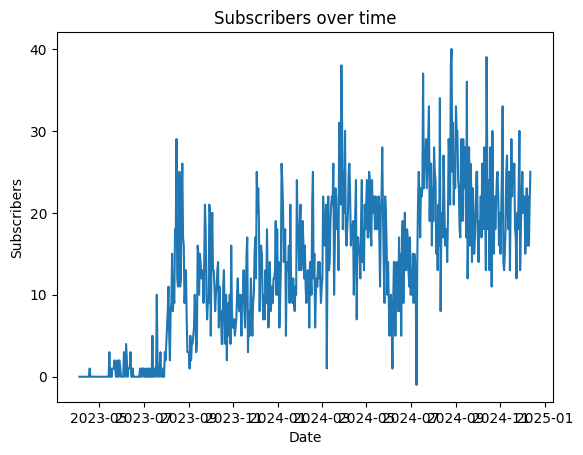

In [3]:
plot_data(clean_df["Subscribers"], title="Subscribers over time", x_label="Date", y_label="Subscribers")

In [4]:
x_train, x_test, y_train, y_test, scaler = prepare_train_test_data(data, time_step_in=30, time_step_out=30, test_size=0.2)

x_train shape: (447, 30), y_train shape: (447, 30), x_test shape: (112, 30), y_test shape: (112, 30)


In [5]:
x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)
print(f"X_test shape => {x_test.shape}\nX_train shape => {x_train.shape}")

X_test shape => (112, 30, 1)
X_train shape => (447, 30, 1)


## definition model

In [6]:
lstm_model=Sequential()
lstm_model.add(LSTM(50,return_sequences=True,input_shape=(30,1)))
lstm_model.add(LSTM(50,return_sequences=True))
lstm_model.add(LSTM(50))
lstm_model.add(Dense(30))
lstm_model.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=0.03), metrics=['mean_absolute_error'])
lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 30)             │         1,530 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,330 (204.41 KB)

 Trainable params: 52,330 (204.41 KB)

 Non-trainable params: 0 (0.00 B)

# Cross Validation

In [7]:
tscv = TimeSeriesSplit(n_splits=5)
loss_total = []

for i, (train_index, test_index) in enumerate(tscv.split(x_train), 1):
    X_tr, X_val = x_train[train_index], x_train[test_index]
    y_tr, y_val = y_train[train_index], y_train[test_index]
    
    history = lstm_model.fit(
        X_tr, y_tr,  
        epochs=100, 
        validation_data=(X_val, y_val),  
        verbose=0  
    )
    
    y_pred = lstm_model.predict(X_val)
    loss = mean_absolute_error(y_val, y_pred)
    loss_total.append(loss)
    
  
    print(f"Fold {i}:")
    print(f"  Training data size: {X_tr.shape}")
    print(f"  Validation data size: {X_val.shape}")
    print(f"  MAE: {loss:.4f}")
    print("-" * 30)


mean_loss = np.mean(loss_total)
print(f'\nMean Loss (MAE) over all folds: {mean_loss:.4f}')

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step
Fold 1:
  Training data size: (77, 30, 1)
  Validation data size: (74, 30, 1)
  MAE: 0.2661
------------------------------
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Fold 2:
  Training data size: (151, 30, 1)
  Validation data size: (74, 30, 1)
  MAE: 0.1235
------------------------------
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Fold 3:
  Training data size: (225, 30, 1)
  Validation data size: (74, 30, 1)
  MAE: 0.1382
------------------------------
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Fold 4:
  Training data size: (299, 30, 1)
  Validation data size: (74, 30, 1)
  MAE: 0.1899
------------------------------
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Fold 5:
  Training data size: (373, 30, 1)
  Validation data size: (74, 30, 1)
  MAE: 0.1964
------------------------------

Mean Loss (MAE) over all folds: 0.1828


In [8]:
# first sample from x_test and reshape it to (1, time_steps, features)
y_next_30 = lstm_model.predict(x_test[0].reshape(1, x_test.shape[1], x_test.shape[2]))
y_next_30=scaler.inverse_transform(y_next_30) 
y_next_30=np.round(y_next_30)
print(y_next_30)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
[[16. 16. 15. 14. 12. 13. 15. 14. 14. 15. 14. 13. 12. 13.  9. 10. 11. 11.
  11. 16. 13. 11. 13. 13. 13. 14. 13. 13. 11. 14.]]


In [9]:
x_train= x_train.reshape(x_train.shape[0], -1)
x_test= x_test.reshape(x_test.shape[0], -1)
print(f"X_test shape => {x_test.shape}\nX_train shape => {x_train.shape}")

X_test shape => (112, 30)
X_train shape => (447, 30)


In [10]:
x_test=scaler.inverse_transform(x_test)
x_train=scaler.inverse_transform(x_train)

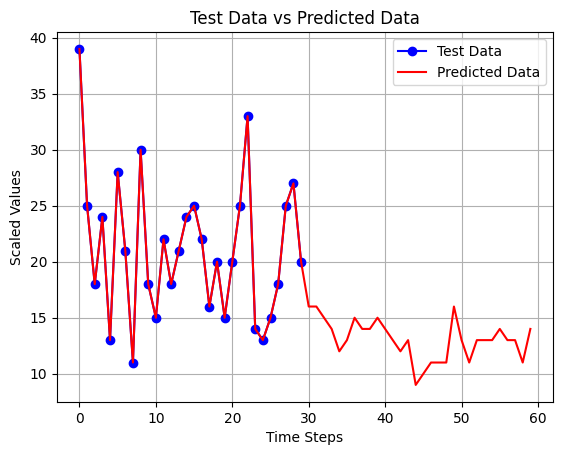

In [11]:
plt.plot(x_test[-1], label='Test Data', color='blue', marker='o')
plt.plot(np.hstack([x_test[-1], y_next_30.reshape(-1)]), label='Predicted Data', color='red')
plt.title('Test Data vs Predicted Data')
plt.xlabel('Time Steps')
plt.ylabel('Scaled Values')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
last_date = clean_df.index[-1]
total_sub=np.sum(clean_df["Subscribers"])
total_next_30=np.sum(y_next_30)
total_next_30=np.round(total_next_30)
print(f"Total subscribers till {last_date}: {total_sub}, next_30_days: {total_next_30} => final after 30 days: {total_sub + total_next_30}")

Total subscribers till 2024-12-12 00:00:00: 8117, next_30_days: 392.0 => final after 30 days: 8509.0


In [13]:
avg_sub = np.mean(np.array(clean_df['Subscribers']))
avg_sub * 30

393.3925686591276